In [1]:
from __future__ import print_function
import pylab as pl
import pandas as pd
import numpy as np

import scipy.stats

%pylab inline

import os
import sys
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


In [2]:
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIDATA")

In [3]:
### A function to download the data

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [5]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

In [6]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [7]:
df.drop(['tripduration', 'starttime', 'stoptime', 
        'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid',
       'usertype', 'birth year', 'gender'], axis=1, inplace=True)

In [8]:
index_id = df['start station id'].value_counts().head(50).index
count_id = df['start station id'].value_counts().head(50).values
most = pd.DataFrame([index_id,count_id]).T
most.columns=["start station id","count"]
most.head()

,start station id,count
0,521,4157
1,293,3186
2,318,3139
3,435,2988
4,490,2637


In [9]:
df = df[df['start station id'].isin(index_id)]
df = df.drop_duplicates(subset='start station id', keep='first', inplace=False)
df = pd.merge(df, most, on='start station id', how='inner') 
df['count'] = df['count'].astype(float)
df

,start station id,start station name,start station latitude,start station longitude,count
0,498,Broadway & W 32 St,40.748549,-73.988084,1501.0
1,517,Pershing Square South,40.751581,-73.977910,1952.0
2,488,W 39 St & 9 Ave,40.756458,-73.993722,1607.0
3,285,Broadway & E 14 St,40.734546,-73.990741,2232.0
4,382,University Pl & E 14 St,40.734927,-73.992005,1992.0
5,509,9 Ave & W 22 St,40.745497,-74.001971,1497.0
6,327,Vesey Pl & River Terrace,40.715338,-74.016584,1565.0
7,536,1 Ave & E 30 St,40.741444,-73.975361,1518.0
8,293,Lafayette St & E 8 St,40.730287,-73.990765,3186.0
9,168,W 18 St & 6 Ave,40.739713,-73.994564,1802.0


In [10]:
nyshp = gpd.read_file('geo_export_nyc.shp')
nyshp['puma'] = nyshp['puma'].astype(int)
nyshp = nyshp[(nyshp['puma'] > 3800) & (nyshp['puma'] < 3900)]

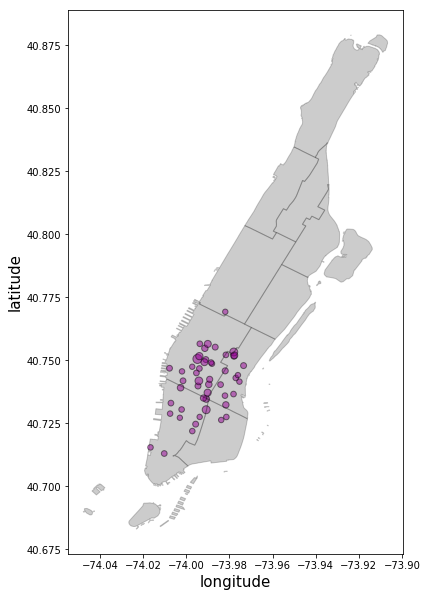

In [11]:
fig, ax = pl.subplots(figsize=(6,10))
df.plot(kind='scatter', x='start station longitude', y='start station latitude',
        ax = ax, alpha = 0.5, marker='o', edgecolor='black',s = df['count']/50, c = 'm')
nyshp.plot(ax=ax, color='black', edgecolor='black', alpha=0.2)
ax.set_xlabel("longitude", fontsize=15)
ax.set_ylabel("latitude", fontsize=15)

### Figure 1. The top 50 most visted Citi Bike stations to rent bikes based on data of January 2015. The point size is proportional to the number of records.